# Basic SBI Model Training

In this tutorial, we will walk through the process of training a simulation-based inference (SBI) model using the `synference` package. We will assume we already have a library of simulations and corresponding parameters.


First let's consider the training process more generally. The main steps involved in training an SBI model are:
1. **Prepare the Simulation Data**: Gather a set of simulations and their corresponding parameters.
2. **Choose a Model Architecture**: Select an appropriate neural network architecture for the SBI model.
3. **Define the Training Procedure**: Set up the training loop, loss function, and optimization algorithm.
4. **Train the Model**: Run the training process and monitor performance.
5. **Evaluate the Model**: Assess the trained model's performance on a validation set.

Now let's look at how to implement these steps using `synference`.


In [1]:
from synference import SBI_Fitter

From the output of the library generation tutorials, we should have a HDF5 file called `test_model_grid.hdf5` in our 'grids/' directory. If you don't have this file, please refer to the [Library Generation](../library_gen/basic_library_generation.ipynb) tutorial.

We can directly use this file to instantiate a `SBI_Fitter` instance, which is the class which handles training and evaluating SBI models in `synference`.


In [2]:
fitter = SBI_Fitter.init_from_hdf5(
    model_name="test", hdf5_path="../example_libraries/test_model_library.hdf5"
)

# Feature and Parameter Arrays

Now this fitter has loaded the generated observations and parameters from the HDF5 file. Note that the data is not yet normalized or set up with the correct features for training. We will handle that in the next steps.

We can see the names of the observations.

In [3]:
print(fitter.raw_observation_names)

['JWST/NIRCam.F070W' 'JWST/NIRCam.F090W' 'JWST/NIRCam.F115W'
 'JWST/NIRCam.F150W' 'JWST/NIRCam.F200W' 'JWST/NIRCam.F277W'
 'JWST/NIRCam.F356W' 'JWST/NIRCam.F444W']


The names of the features:

In [4]:
print(fitter.parameter_names)

['redshift' 'log_mass' 'tau_v' 'tau' 'peak_age' 'log10metallicity']


and any associated parameters units:

In [5]:
print(fitter.parameter_units)

['dimensionless' 'log10_Msun' 'mag' 'dimensionless' 'Myr' 'log10(Zmet)']


The actual array itself is stored in the `parameter_array` attribute.

In [6]:
print(fitter.parameter_array)

[[ 2.05416274e+00  1.04035606e+01  1.22474718e+00  9.36861515e-01
   1.69158648e+03 -3.13879132e+00]
 [ 2.00016856e+00  1.04899187e+01  1.28473628e+00  1.60899329e+00
   3.02503141e+03 -3.87390995e+00]
 [ 2.18753195e+00  1.15228844e+01  2.18956232e+00  1.20334947e+00
   1.86831172e+03 -3.46571136e+00]
 [ 2.11274648e+00  9.81967258e+00  5.74459910e-01  8.06611896e-01
   2.01560364e+03 -1.89818966e+00]
 [ 2.44652700e+00  9.17687321e+00  1.38670945e+00  1.77724314e+00
   3.07231417e+02 -2.88550878e+00]
 [ 6.84367716e-01  1.14148254e+01  2.61994505e+00  3.89508367e-01
   3.59630292e+03 -1.86997616e+00]
 [ 1.49105906e-01  1.00042429e+01  1.95352912e+00  1.27394879e+00
   1.13156527e+04 -2.40571117e+00]
 [ 1.71895242e+00  1.17945662e+01  1.94888246e+00  2.07960412e-01
   1.57720040e+03 -3.86293936e+00]
 [ 2.84610391e+00  9.41966534e+00  2.85131145e+00  8.91395509e-01
   1.19775692e+03 -3.77944398e+00]
 [ 2.45635724e+00  1.03770952e+01  1.80910027e+00  2.73230791e-01
   2.36855774e+03 -1.7107

And a similar logic for the observations:

In [7]:
print(fitter.raw_observation_grid)

[[1.55361035e+02 6.62787615e+01 2.93631144e+02 6.01755184e+01
  6.08683670e+00 2.52897265e+03 6.31139334e+03 5.55954909e+02
  3.01451722e-01 7.46139935e-02 1.77478449e+01 2.84698937e+04
  1.21674001e+04 3.91650543e-03 4.49461992e+01 3.98751947e+01
  3.49210537e+00 4.03298200e+01 5.09577721e+09 2.57451816e+01
  9.79124011e+00 1.37660187e-01 1.12871233e+01 7.47147284e+05
  1.47271084e+00 3.31803169e+01 6.49741609e+01 7.97400174e-01
  2.99735306e+01 3.01003478e+03 1.78139231e+01 7.48521722e-01
  9.49261760e+01 2.07935670e+00 2.86336816e-05 5.75082924e-03
  3.25993542e-02 8.00058776e+02 1.03138991e+00 4.22555506e-01
  2.02875575e+02 2.93391914e+00 2.45030230e-02 8.61272076e-02
  7.40968399e+04 6.60761033e+01 9.02332272e+00 1.12874656e+04
  3.36672808e+04 1.01508678e+00 1.07125533e+03 8.76386327e+02
  8.26748183e-01 7.35644949e-02 2.24756746e+03 2.26176337e+03
  1.70852733e+04 7.78096628e-03 3.96013085e+04 8.12530980e+00
  1.48131617e+02 1.50023402e+02 2.47127479e-01 7.94097359e+00
  7.8366

The first step is to turn this raw grid of photometric observations into a set of features that can be used for training. This is done with the `fitter.create_feature_array` method.

This method handles the following tasks:
1. Normalizing the observations (e.g., converting magnitudes to fluxes, normalizing by a reference band, etc.)
2. Creating features from the observations (e.g., colors, ratios, etc.)
3. Removing photometric bands in the library from the feature array that are not present in the observations.
3. Handling missing data (e.g., setting features to NaN if any of the required bands are missing)
4. Adding additional features (e.g., redshift) from the parameter array to the feature array.
5. Adding realistic noise to the features based on a provided noise model (see the [Noise Models](../noise_modelling/noise_models.ipynb) tutorial for more details).
6. Adding photometric uncertainties to the feature array.


The default configuration of this method doesn't do all of these however. By default, all photometric bands are kept, no additional features are added, and no noise is added. The default normalization is to convert the raw array of photometry to AB magnitudes only. 

We call the method below and we can see it prints information about the features it creates.

In [8]:
fitter.create_feature_array();

2025-11-06 17:48:11,873 | synference | INFO     | ---------------------------------------------
2025-11-06 17:48:11,874 | synference | INFO     | Features: 8 features over 100 samples
2025-11-06 17:48:11,875 | synference | INFO     | ---------------------------------------------
2025-11-06 17:48:11,875 | synference | INFO     | Feature: Min - Max
2025-11-06 17:48:11,876 | synference | INFO     | ---------------------------------------------
2025-11-06 17:48:11,877 | synference | INFO     | JWST/NIRCam.F070W: 7.131974 - 42.758 AB
2025-11-06 17:48:11,879 | synference | INFO     | JWST/NIRCam.F090W: 7.108530 - 39.933 AB
2025-11-06 17:48:11,879 | synference | INFO     | JWST/NIRCam.F115W: 7.012560 - 38.354 AB
2025-11-06 17:48:11,880 | synference | INFO     | JWST/NIRCam.F150W: 6.969396 - 36.997 AB
2025-11-06 17:48:11,881 | synference | INFO     | JWST/NIRCam.F200W: 7.133157 - 35.470 AB
2025-11-06 17:48:11,882 | synference | INFO     | JWST/NIRCam.F277W: 7.670149 - 33.243 AB
2025-11-06 17:4

We will proceed with the default configuration for now. More advanced configurations will be covered in later tutorials. Using different normalizations/units or adding additional features can have a significant impact on the performance of the trained SBI model.

Before we do any fitting, we can inspect the feature and parameter arrays to see the distribution of the data.

Firstly we can look at the feature array, and see the distribution of the photometry given our model and feature array configuration. The below figure shows a histogram of each feature in the feature array.

2025-11-06 17:48:13,076 | synference | INFO     | saving /Users/user/Documents/PhD/synference/models/test/plots//feature_histogram.png


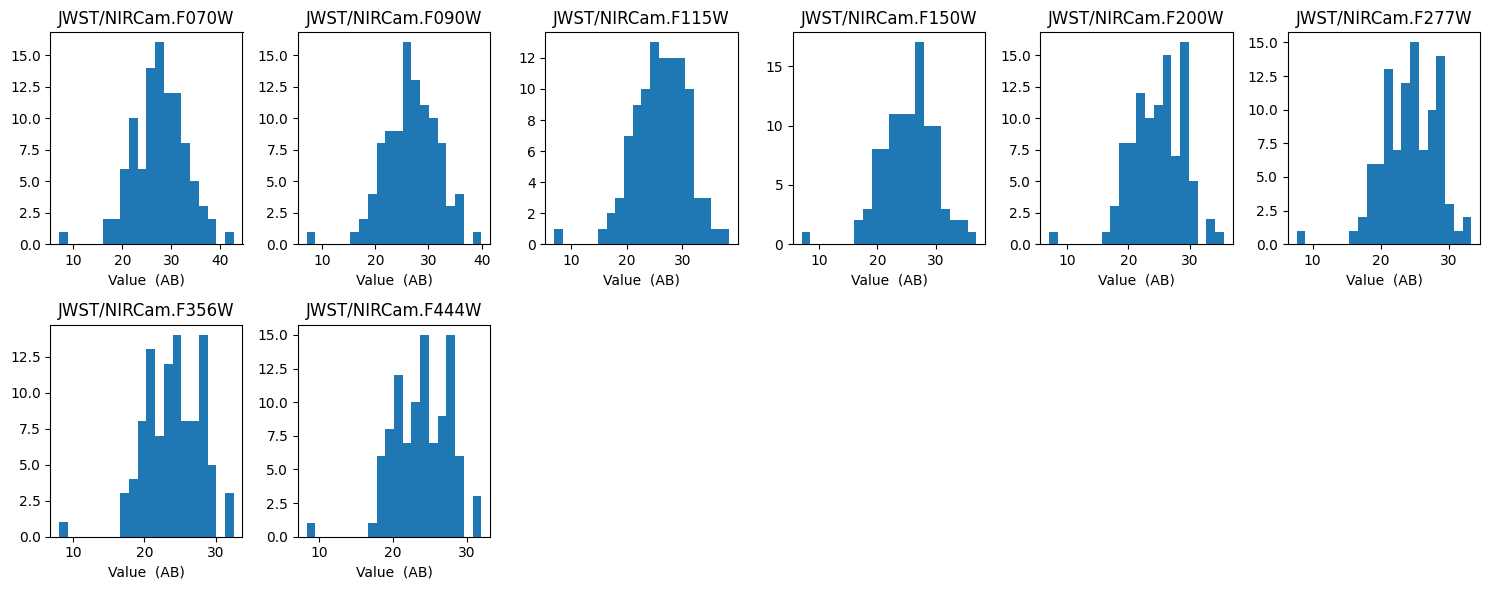

In [9]:
fitter.plot_histogram_feature_array(bins=20);

Secondly we can look at the parameter array, and see the distribution of the parameters given our model and parameter configuration. The below figure shows a histogram of each parameter in the parameter array. We can see that the parameters are uniformly distributed, as expected from our library generation configuration.

2025-11-06 17:48:16,813 | synference | INFO     | saving /Users/user/Documents/PhD/synference/models/test/plots//param_histogram.png


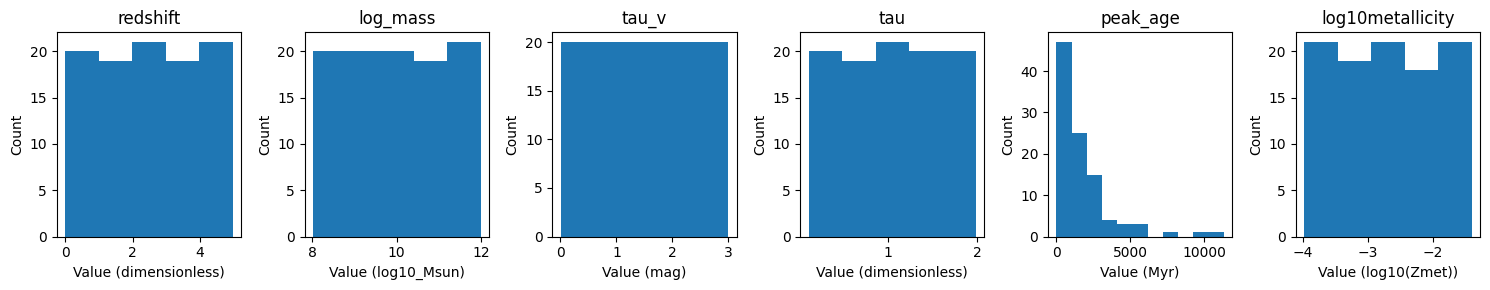

In [10]:
fitter.plot_histogram_parameter_array();

# Training an SBI Model

SBI model training is handled with the `fitter.train_single_sbi` method. This method handles the following tasks:
1. Creating a prior from the parameter array.
2. Setting up the neural density estimator (NDE) for the SBI model.
3. Training the SBI model.
4. Saving the trained model to disk.
5. Plotting diagnostics of the trained model.


We will cover the various options for different SBI configurations in later tutorials. For now, we will proceed with the default configuration.

synference is built on top of the LtU-ILI package, which utilizes `sbi` and `lampe` for the underlying SBI functionality. The default NDE is a `Masked Autoregressive Flow (MAF)` from the `sbi` package. The default prior proposal is a uniform prior over the range of the parameters in the parameter array.

In [11]:
?fitter.run_single_sbi

Signature:
fitter.run_single_sbi(
    train_test_fraction: float = 0.8,
    random_seed: Optional[int] = None,
    backend: str = 'sbi',
    engine: Union[str, List[str]] = 'NPE',
    train_indices: Optional[numpy.ndarray] = None,
    test_indices: Optional[numpy.ndarray] = None,
    n_nets: int = 1,
    model_type: Union[str, List[str]] = 'mdn',
    hidden_features: Union[int, List[int]] = 50,
    num_components: Union[int, List[int]] = 4,
    num_transforms: Union[int, List[int]] = 4,
    training_batch_size: int = 64,
    learning_rate: float = 0.0001,
    validation_fraction: float = 0.2,
    stop_after_epochs: int = 15,
    clip_max_norm: float = 5.0,
    additional_model_args: dict = {},
    save_model: bool = True,
    verbose: bool = True,
    prior_method: str = 'ili',
    out_dir: str = '/Users/user/Documents/PhD/synference/models/',
    plot: bool = True,
    name_append: str = 'timestamp',
    feature_scalar: Callable = <class 'sklearn.preprocessing._data.StandardScaler'>,


The primary arguments to the `fitter.train_single_sbi` method are:
- `train_test_fraction`: The fraction of the data to use for training. The rest is used for validation. The default is 0.8.
- `validation_fraction`: The fraction of the training data to use for validation during training. The default is 0.2.
- `backend`: The backend to use for training. Either `sbi` or `lampe`. The default is `sbi`.
- `hidden_features`: The number of hidden features in the NDE. The default is 50.
- `num_components/transforms`: The number of components or transforms in the NDE. The default is 4.
- `training_batch_size`: The batch size for training. The default is 64.
- `stop_after_epochs`: The number of epochs with no improvement to stop training. The default is 15.

There are other methods to turn on or off plotting, model saving, validation, etc. See the docstring for more details. 

Now we will run the training, and quite a lot of things will be printed. We are setting `name_append` to 'test_1' so that the trained model is saved with a unique name. If left as the default a timestamp will be used.

2025-11-06 17:48:18,409 | synference | INFO     | Loading existing model from /Users/user/Documents/PhD/synference/models/test/test_test_1_params.pkl
2025-11-06 17:48:19,047 | synference | INFO     | Loaded model from /Users/user/Documents/PhD/synference/models/test/test_test_1_posterior.pkl.
2025-11-06 17:48:19,055 | synference | INFO     | Device: cpu
2025-11-06 17:48:19,296 | synference | INFO     | [  4.71776485  10.91856003   2.10899472   1.62835562 839.54782677
  -3.49632525]


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Saving single posterior plot to /Users/user/Documents/PhD/synference/models/test/plots/test_1/test_1582_plot_single_posterior.jpg...


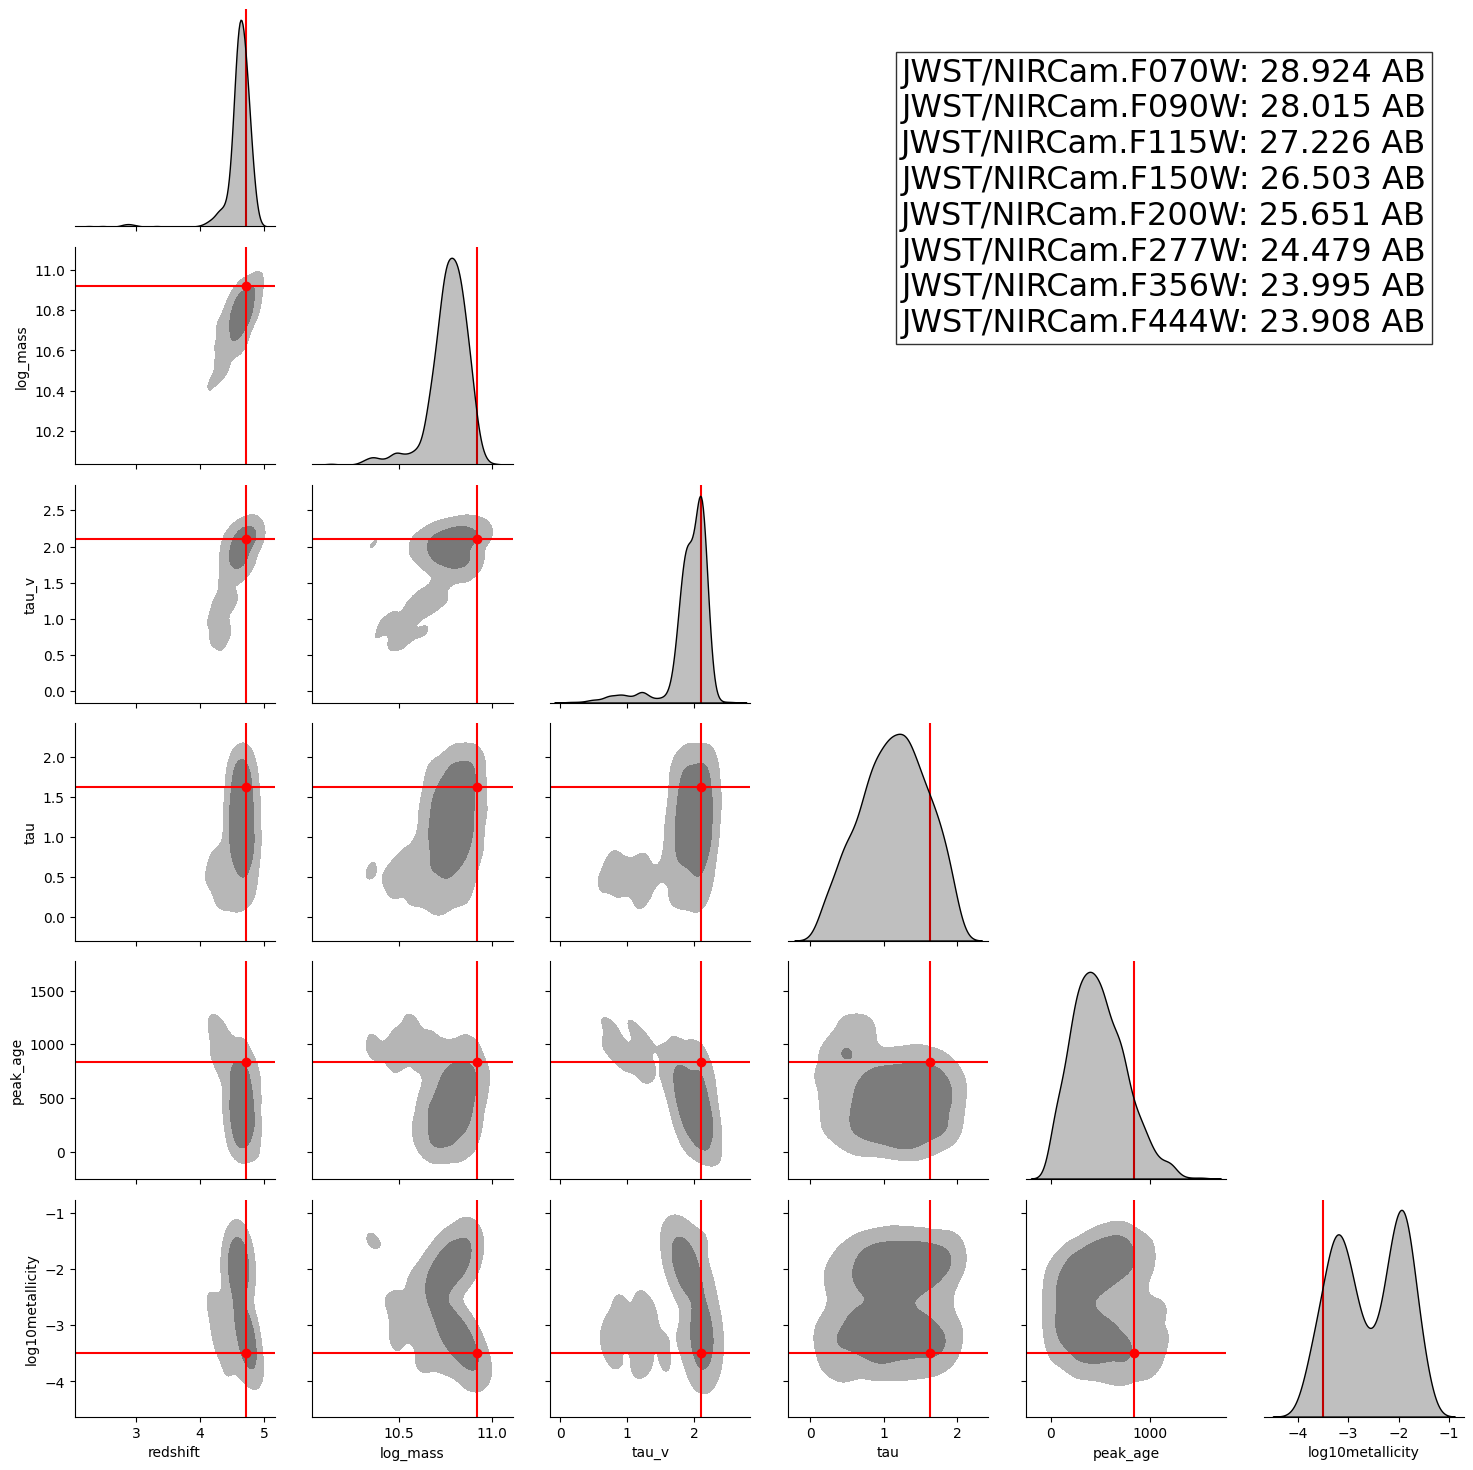

In [12]:
posterior_model, stats = fitter.run_single_sbi(
    name_append="test_1", random_seed=42, hidden_features=256, num_components=64
)


The first part of the output shows we split the training data into the training and testing splits, then we create the prior from the parameter grid, and show the ranges of each parameter.

The next part shows us creating the neural density estimator (NDE) model, which is a mixture density network (MDN) with 4 components. The model is created using the `sbi` package, which is built on top of PyTorch.

Then the actual training happens - we see the training epochs increment until the model has stopped improving on the validation set. The training stops after 15 epochs with no improvement, as we set `stop_after_epochs=15`.

The model is pickled and saved to the output directory for this model, which is `models/test_model/` by default. The summary of the training model is saved as a .json file in the same directory. And the configuration of the fitter is also pickled and saved to the same directory, which saves the feature and parameter configuration used for training. A model can be re-loaded later using the `fitter.load_model_from_pkl` method. We can save in a different format by changing the `save_method` argument to e.g. `torch` or `hickle`.

Now we have a trained model. The validation metrics run which include:
1. A posterior corner plot for a random observation from the test set.
2. A loss plot which shows the training and validation loss over epochs.
3. A coverage plot which shows how well the credible intervals of the posterior match the true parameters.
4. A ranks histogram which shows how well the posterior samples match the true parameters.
5. A log_probabiity plot which shows the log probability of the true parameters under the posterior.
6. A True vs predicted plot which shows the true parameters vs the maximum a posteriori (MAP) estimate from the posterior.


These plots are shown in the output, and also saved to the `plots/` directory in the output folder for this model.

# Loading a Trained Model

We can load a trained model into an exisiting `SBI_Fitter` instance using the `fitter.load_model_from_pkl` method. This method takes the path to the pickled model file as an argument. 

If only one model is present in the directory, we can simply provide the directory path and the method will find the model file automatically. If multiple models are present, we can provide the full path to the model file.

In [13]:
fitter.load_model_from_pkl("test/test_test_1_posterior.pkl");

2025-11-06 17:48:38,322 | synference | INFO     | Loaded model from /Users/user/Documents/PhD/synference/models/test/test_test_1_posterior.pkl.
2025-11-06 17:48:38,324 | synference | INFO     | Device: cpu


Alternatively, we can create a new `SBI_Fitter` instance and load the model into that instance, using the class method `load_saved_model`. This method takes the path to the pickled model file as an argument, and returns a new `SBI_Fitter` instance with the model loaded.

In [14]:
new_fitter = SBI_Fitter.load_saved_model("test/test_test_1_posterior.pkl")

2025-11-06 17:48:39,370 | synference | INFO     | Loaded model from /Users/user/Documents/PhD/synference/models/test/test_test_1_posterior.pkl.
2025-11-06 17:48:39,375 | synference | INFO     | Device: cpu


# Plotting model loss

We can plot the model loss using the `fitter.plot_loss` method. This method will create a plot of the training and validation loss over epochs, and save it to the `plots/` directory in the output folder for this model. By default, it will not overwrite existing plots, but you can change this with the `overwrite` argument.

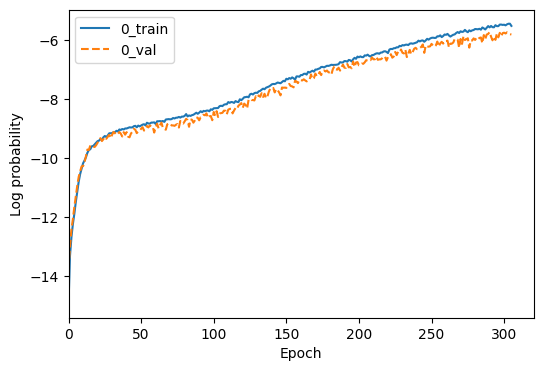

In [15]:
fitter.plot_loss(overwrite=True);

# Plotting validation metrics

Whilst it does happen automatically during training, we can also plot the validation metrics of a trained model using the `fitter.plot_diagnostics` method. You can provide your own validation set, or by default it will use the test set from the last training run. By default, it will not create existing plots in the `plots/` directory, but you can change this with the `overwrite` argument.

2025-11-06 17:48:41,298 | synference | INFO     | [ 2.24194074e+00  1.17340765e+01  2.37600374e+00  1.57886779e+00
  1.79647676e+03 -3.40415168e+00]


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Saving single posterior plot to /Users/user/Documents/PhD/synference/models/test/plots/test_1102_plot_single_posterior.jpg...


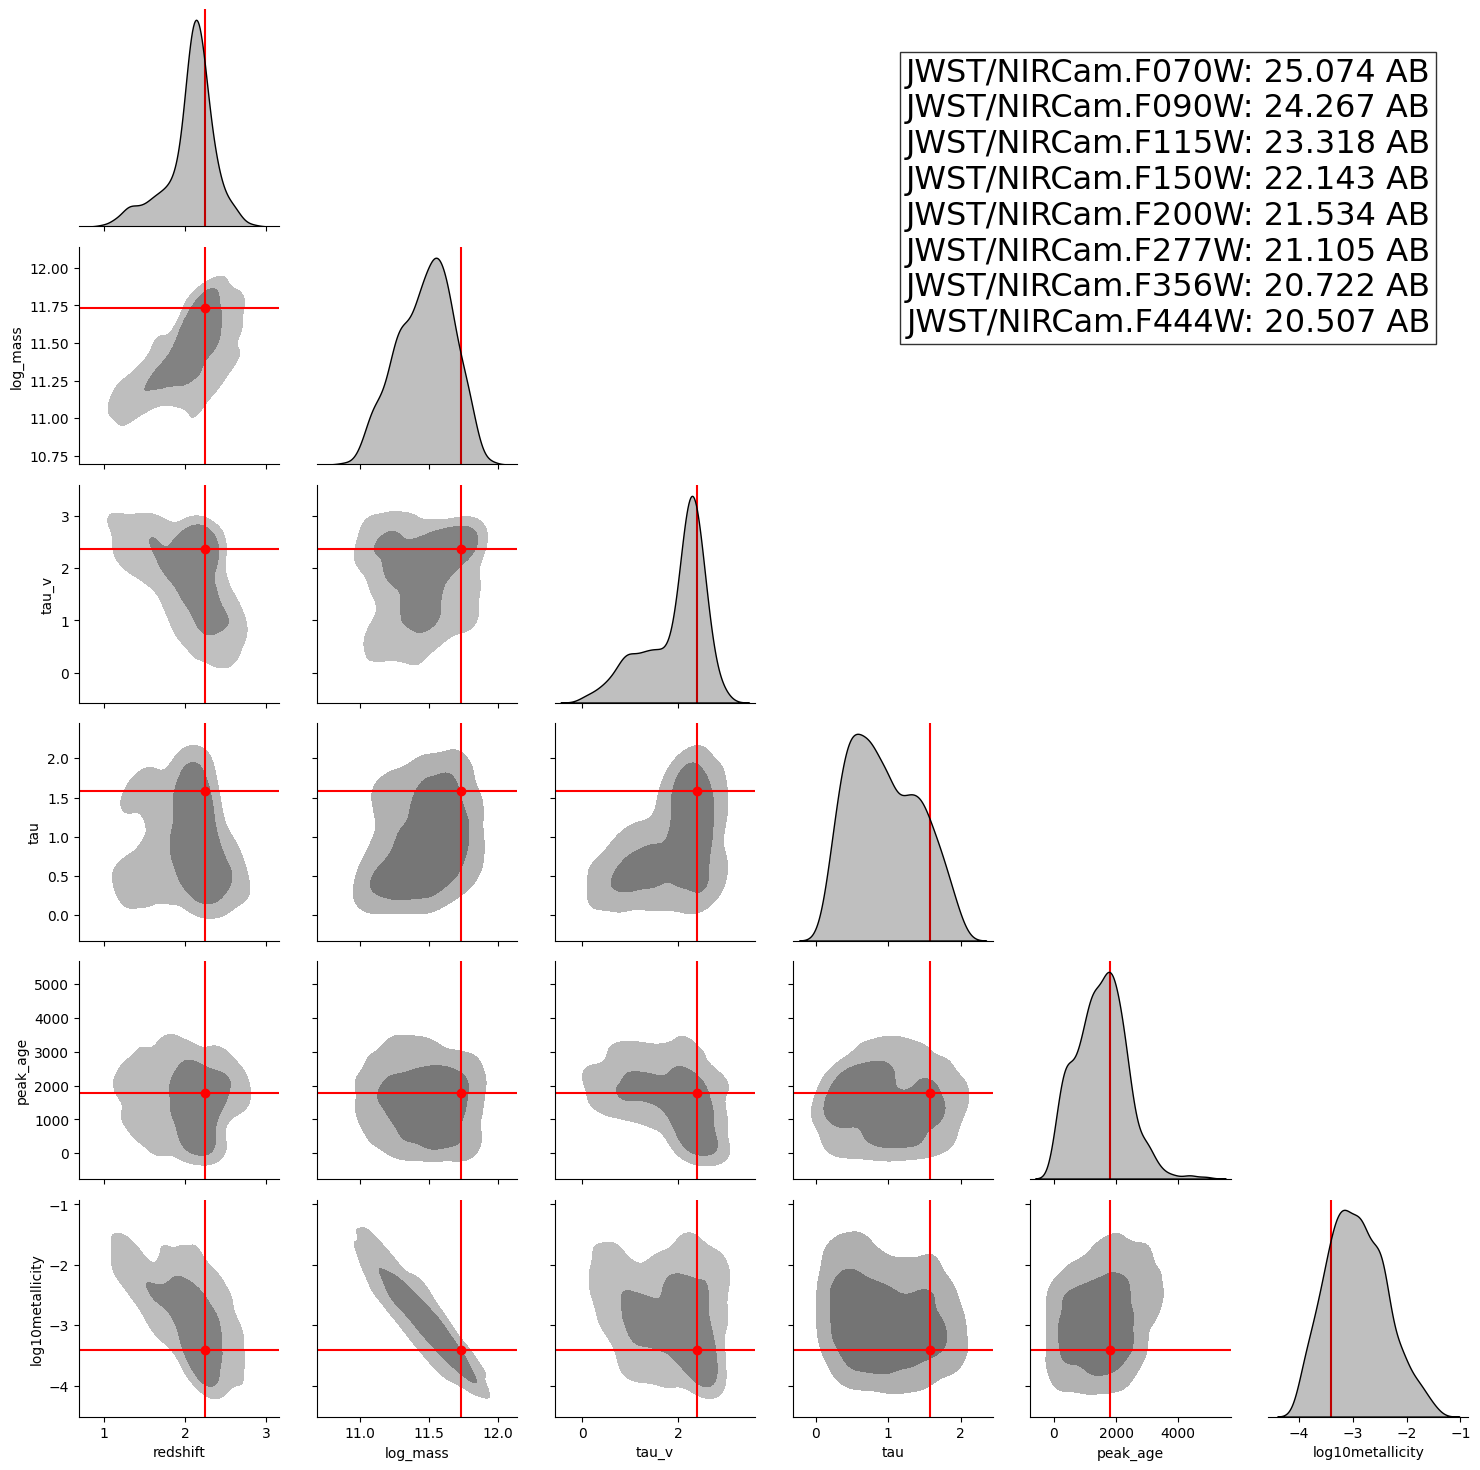

In [16]:
fitter.plot_diagnostics();

# Getting model metrics

We can print and save metrics of the trained model using the `fitter.evaluate_model` method. This method will print the metrics to the console, and also save them to a .json file in the output directory for this model. The metrics include:
- TARP (Tests of Accuracy with Random Points)
- Log DPIT (Logarithmic Deviation of the Probability Integral Transform)
- Mean Log Probability
- Parameter-specific metrics (MSE, RMSE, Mean Absolute Error, Median Absolute Error, R-squared, Normalized RMSE)


In [17]:
fitter.evaluate_model();

Sampling from posterior:  60%|██████    | 1203/2000 [00:08<00:05, 147.36it/s]WARNING:root:Only 0.555% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    939 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
Sampling from posterior:  87%|████████▋ | 1739/2000 [00:12<00:01, 185.16it/s]WARNING:root:Only 0.282% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    969 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
Sampling from posterior:  98%|█████████▊| 1963/2000 [00:13<00:00, 189.36it/s]WARNING:root:Only 0.509% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    944 samples. Consider interrupting (Ctrl-C) and switching to
                    `bu

2025-11-06 17:52:57,511 | synference | INFO     | ============================================================
2025-11-06 17:52:57,517 | synference | INFO     | MODEL PERFORMANCE METRICS
2025-11-06 17:52:57,519 | synference | INFO     | ============================================================
2025-11-06 17:52:57,519 | synference | INFO     | Full Model Metrics:
2025-11-06 17:52:57,520 | synference | INFO     | ----------------------------------------
2025-11-06 17:52:57,521 | synference | INFO     | TARP..................... 0.090067
2025-11-06 17:52:57,521 | synference | INFO     | LOG DPIT MAX............. 0.516195
2025-11-06 17:52:57,522 | synference | INFO     | MEAN LOG PROB............ -5.484673
2025-11-06 17:52:57,523 | synference | INFO     | Parameter-Specific Metrics:
2025-11-06 17:52:57,524 | synference | INFO     | ----------------------------------------
2025-11-06 17:52:57,526 | synference | INFO     | Metric        redshift  log_mass     tau_v       tau        peak_a

# Posterior Samples

We can sample the posterior for a given observation using the `fitter.sample_posterior` method. This method takes an observation, or a set of observations, as an argument, and returns samples from the posterior distribution. If no observation is provided, it will draw posterior samples for all observations in the test set.

In [18]:
fitter.sample_posterior()

Sampling from posterior:  47%|████▋     | 945/2000 [00:07<00:06, 158.06it/s]WARNING:root:Only 0.945% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    896 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
Sampling from posterior:  60%|█████▉    | 1190/2000 [00:09<00:06, 129.79it/s]WARNING:root:Only 0.555% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    939 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
Sampling from posterior:  87%|████████▋ | 1732/2000 [00:11<00:01, 219.51it/s]WARNING:root:Only 0.191% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    979 samples. Consider interrupting (Ctrl-C) and switching to
                    `bui

array([[[ 4.40319330e-01,  9.09916115e+00,  1.39989102e+00,
          7.24955022e-01,  6.89050781e+03, -2.71193576e+00],
        [ 5.02633870e-01,  9.54269409e+00,  4.20984834e-01,
          1.89758730e+00,  7.60800488e+03, -2.36361670e+00],
        [ 4.29935008e-01,  9.38728523e+00,  1.35065281e+00,
          1.66078711e+00,  6.68562354e+03, -2.77364492e+00],
        ...,
        [ 4.29828942e-01,  9.52354622e+00,  1.80500877e+00,
          8.38589609e-01,  3.19203857e+03, -3.62698889e+00],
        [ 4.47475076e-01,  9.07920456e+00,  9.02869940e-01,
          1.56794000e+00,  2.81380444e+03, -2.04133248e+00],
        [ 4.10753012e-01,  9.18367958e+00,  1.18032289e+00,
          1.19631076e+00,  3.90576587e+03, -2.49993968e+00]],

       [[ 2.90147662e+00,  8.37973690e+00,  2.07074881e+00,
          4.97765929e-01,  6.13704895e+02, -1.97727311e+00],
        [ 2.97392535e+00,  8.42537022e+00,  2.32516837e+00,
          3.16987693e-01,  3.36642426e+02, -1.69683313e+00],
        [ 3.81361

# Next Steps

In the next tutorials, we will cover more advanced configurations for training SBI models, including different feature and parameter configurations, different NDEs, and different prior proposals. We will also cover how to use the trained models for inference on real data.